This tutorial guides you on how to train a Gradient Boosting model using decision trees with the `tf.estimator` APIs. Boosted trees are the popular ML approach for both regression and classification. It is a kind of ensemble technique to summarize the result from many tree models.

This tutorial guides you further on understanding the Boosted Tree model. You can inspect the model from the `local` and the `global`. **From the local aspect, you are going to understand the model on the individual example level**. To distinguish the importance of features, we introduce the `directional feature contributions (DFCs)` detecting what features most contribute to the prediction. **From the global scope, we introduce `permutation feature importances`.** The permutation feature importance is defined to be the decrease in a model score when a feature value is randomly shuffled. This procedure breaks the relationship between the feature and the target. This procedure causes a drop in the model score so that you can understand how much the model depends on the feature.

Reference:
* Boosted trees: https://www.tensorflow.org/tutorials/estimator/boosted_trees
* Boosted trees mooel understanding: https://www.tensorflow.org/tutorials/estimator/boosted_trees_model_understanding

In [0]:
!pip install -q tf-nightly

In [2]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import seaborn as sns

tf.random.set_seed(123)
sns_colors = sns.color_palette('colorblind')

print("Tensorflow Version: {}".format(tf.__version__))
print("Eager Mode: {}".format(tf.executing_eagerly()))
print("GPU {} available".format("is" if tf.config.experimental.list_physical_devices("GPU") else "not"))

Tensorflow Version: 2.2.0-dev20200114
Eager Mode: True
GPU is available


# Data Preprocessing and Exploring

In [0]:
dftrain = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/train.csv")
dfeval = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/eval.csv")
y_train = dftrain.pop("survived")
y_eval = dfeval.pop("survived")

In [4]:
dftrain.head(5)

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [5]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [6]:
dftrain.shape[0], dfeval.shape[0]

(627, 264)

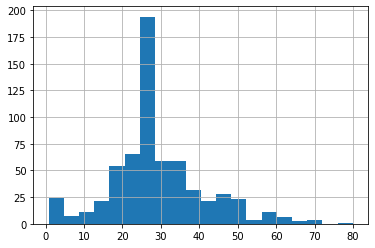

In [7]:
dftrain["age"].hist(bins=20)
plt.show()

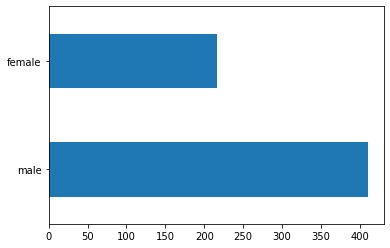

In [8]:
dftrain["sex"].value_counts().plot(kind="barh")
plt.show()

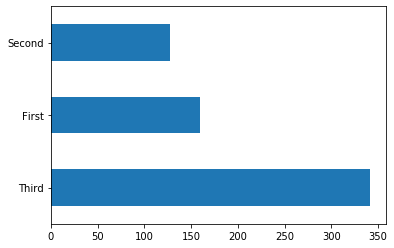

In [9]:
dftrain["class"].value_counts().plot(kind='barh')
plt.show()

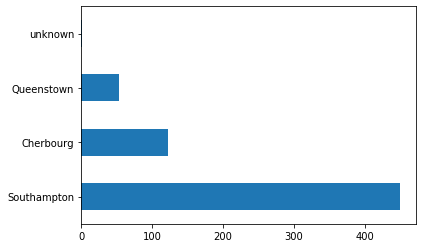

In [10]:
dftrain["embark_town"].value_counts().plot(kind='barh')
plt.show()

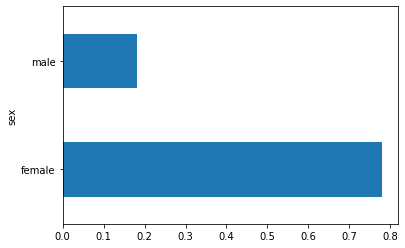

In [11]:
pd.concat([dftrain, y_train], axis=1).groupby(['sex'])["survived"].mean().plot(kind='barh')
plt.show()

# Create Feature Columns and Input functions

In [0]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

In [0]:
feature_columns = []

for feat in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feat].unique()
  # estimators require dense features
  feature_columns.append(tf.feature_column.indicator_column(
    tf.feature_column.categorical_column_with_vocabulary_list(
      key=feat, vocabulary_list=vocabulary
    )
  ))

for feat in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(key=feat))

Let's inspect the data first.

In [14]:
example_data = dftrain.iloc[:10,:]
example_data

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y
5,male,2.0,3,1,21.0750,Third,unknown,Southampton,n
6,female,27.0,0,2,11.1333,Third,unknown,Southampton,n
7,female,14.0,1,0,30.0708,Second,unknown,Cherbourg,n
8,female,4.0,1,1,16.7000,Third,G,Southampton,n
9,male,20.0,0,0,8.0500,Third,unknown,Southampton,y


In [15]:
class_feat = tf.keras.layers.DenseFeatures([feature_columns[3]])(dict(example_data))
class_feat.numpy()

array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

Now you can create an input function that feeds the dataset and the label into the model during training and evaluation.

In [0]:
NUM_EXAMPLES = len(dftrain)

def make_input_fn(X, y, n_epochs=1, shuffle=True, batch_size=NUM_EXAMPLES):
  def input_fn():
    # repeat == None: endless repeat
    ds = tf.data.Dataset.from_tensor_slices((dict(X), y)).repeat(n_epochs)
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size)  # no need to do shuffle due to in-memory data
    return ds
  return input_fn

In [0]:
def make_in_memory_train_input_fn(X, y):
  """Used when the whole data is saved in memory.
  It is no need to batch the dataset.
  """
  y = np.expand_dims(y, axis=1)
  def input_fn():
    return dict(X), y
  return input_fn

In [0]:
train_input_fn = make_input_fn(dftrain, y_train, n_epochs=None)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=1)

You can also use the input_fn method to get a batch of dataset.

In [19]:
_ds = make_input_fn(dfeval, y_eval, shuffle=False, batch_size=3)()
_ds

<BatchDataset shapes: ({sex: (None,), age: (None,), n_siblings_spouses: (None,), parch: (None,), fare: (None,), class: (None,), deck: (None,), embark_town: (None,), alone: (None,)}, (None,)), types: ({sex: tf.string, age: tf.float64, n_siblings_spouses: tf.int32, parch: tf.int32, fare: tf.float64, class: tf.string, deck: tf.string, embark_town: tf.string, alone: tf.string}, tf.int32)>

In [20]:
for _data, _label in _ds.take(1):
  print(_data.keys())
  print(_data['sex'].numpy())
  print(_label)

dict_keys(['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone'])
[b'male' b'male' b'female']
tf.Tensor([0 0 1], shape=(3,), dtype=int32)


# Training, Evaluating and Predicting

The following is a linear model as the baseline.

In [21]:
linear_est = tf.estimator.LinearClassifier(feature_columns)

# train the model
linear_est.train(input_fn=train_input_fn, max_steps=100)

# evaluate the model
result = linear_est.evaluate(input_fn=eval_input_fn)
clear_output()
print(pd.Series(result))

accuracy                  0.734848
accuracy_baseline         0.625000
auc                       0.833639
auc_precision_recall      0.792803
average_loss              0.479465
label/mean                0.375000
loss                      0.479465
precision                 0.643564
prediction/mean           0.406368
recall                    0.656566
global_step             100.000000
dtype: float64


Next you are going to build a Boosted Trees model. Both regression and classification are supported via the `BoostedTreesClassifier` and the `BoostedTreesClassifier` API respectively.

In [22]:
params = {
    'n_trees': 50,
    'max_depth': 3,
    'n_batches_per_layer': 1,
    # You have to set the center_bias to True to get DFCs.
    'center_bias': True
}

# Because all dataset is loaded into the memory, use entire dataset per layer.
n_batches = 1
est = tf.estimator.BoostedTreesClassifier(feature_columns=feature_columns,
                                          **params)

# train the model
est.train(train_input_fn, max_steps=100)

# evaluate the model
result = est.evaluate(eval_input_fn)
clear_output()
print(pd.Series(result))

accuracy                  0.821970
accuracy_baseline         0.625000
auc                       0.862504
auc_precision_recall      0.853644
average_loss              0.418333
label/mean                0.375000
loss                      0.418333
precision                 0.782609
prediction/mean           0.386008
recall                    0.727273
global_step             100.000000
dtype: float64


Make the prediction.

In [23]:
preds = list(est.predict(eval_input_fn))
preds[:2]

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpk3tua9_4/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


[{'all_class_ids': array([0, 1], dtype=int32),
  'all_classes': array([b'0', b'1'], dtype=object),
  'class_ids': array([1]),
  'classes': array([b'1'], dtype=object),
  'logistic': array([0.8853182], dtype=float32),
  'logits': array([2.0437863], dtype=float32),
  'probabilities': array([0.11468174, 0.8853182 ], dtype=float32)},
 {'all_class_ids': array([0, 1], dtype=int32),
  'all_classes': array([b'0', b'1'], dtype=object),
  'class_ids': array([0]),
  'classes': array([b'0'], dtype=object),
  'logistic': array([0.1707146], dtype=float32),
  'logits': array([-1.5805713], dtype=float32),
  'probabilities': array([0.8292854 , 0.17071457], dtype=float32)}]

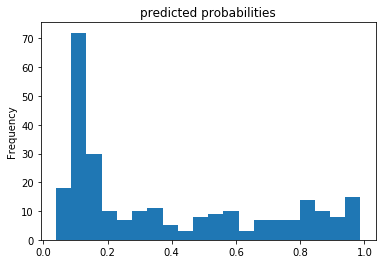

In [24]:
probs = pd.Series([pred["probabilities"][1] for pred in preds])
probs.plot(kind='hist', bins=20, title='predicted probabilities')
plt.show()

# Local Interpretability

Next, you will output the directional feature contributions (DFCs) to explain individual predictions.

In [25]:
pred_dicts = list(est.experimental_predict_with_explanations(eval_input_fn))

INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpk3tua9_4', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tm

In [26]:
# Create DFC Pandas dataframe.
labels = y_eval.values
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])
df_dfc.describe().T

,count,mean,std,min,25%,50%,75%,max
sex,264.0,0.014144,0.121462,-0.109596,-0.076600,-0.070452,0.157837,0.202772
class,264.0,0.026534,0.089283,-0.079473,-0.031677,-0.021071,0.073409,0.225969
embark_town,264.0,-0.006160,0.030870,-0.063145,-0.025835,-0.014016,-0.003259,0.076860
deck,264.0,-0.028806,0.044456,-0.092518,-0.063192,-0.049729,-0.001304,0.207005
age,264.0,-0.023931,0.087066,-0.174179,-0.068987,-0.049069,0.011877,0.414849
fare,264.0,0.021967,0.082514,-0.335447,-0.025016,-0.007749,0.060732,0.246807
alone,264.0,0.001418,0.010202,-0.020235,-0.003872,0.004227,0.008276,0.036037
n_siblings_spouses,264.0,0.002159,0.019644,-0.129914,-0.000253,0.001220,0.011166,0.056161
parch,264.0,0.002287,0.010761,-0.036523,-0.000536,-0.000217,-0.000120,0.067693


In [27]:
df_dfc.head(3)

,sex,class,embark_town,deck,age,fare,alone,n_siblings_spouses,parch
0,-0.094263,0.069324,0.065348,-0.049729,-0.041400,0.026258,0.008779,0.007424,-0.001077
1,0.173995,0.205404,0.002625,-0.019973,-0.098328,0.099609,0.007501,0.011599,-0.000894
2,-0.071140,-0.033421,-0.014016,-0.063633,-0.066862,-0.029608,0.008801,0.000029,-0.000112


A property of DFCs is that the sum of all contributions plus bias is equal to the prediction given an example.

The bias is in the global scope and equal to each example.

In [0]:
bias = pred_dicts[0]['bias']
dfc_prob = df_dfc.sum(axis=1) + bias
np.testing.assert_almost_equal(dfc_prob.values, probs.values)

In [31]:
df_dfc.sum(axis=1)[1], df_dfc.iloc[1,:].sum()

(0.38153892009505647, 0.38153892009505647)

Plot DFCs for an individual passenger.

In [0]:
def _get_color(value):
  """To make positive DFCs plot green, and negative ones plot red."""
  green, red = sns.color_palette()[2:4]
  return green if value >= 0 else red

In [0]:
def _add_feature_values(feature_values, ax):
  """Display feature's values on left of plot."""
  x_coord = ax.get_xlim()[0]
  OFFSET = 0.15

  for y_coord, (feature_name, feat_val) in enumerate(feature_values.items()):
    t = plt.text(x_coord, y_coord - OFFSET, '{:1.4f}'.format(feat_val), size=12)
    t.set_bbox(dict(facecolor='white', alpha=0.5))
  
  from matplotlib.font_manager import FontProperties
  font = FontProperties()
  font.set_weight('bold')
  t = plt.text(x_coord, y_coord + 1 - OFFSET, 
               'feature\nvalue', 
               fontproperties=font, 
               size=12)

In [0]:
def plot_example(_example):
  TOP_N = 8  # how many features viewed
  sorted_ix = _example.abs().sort_values()[-TOP_N:].index
  example = _example[sorted_ix]
  colors = example.map(_get_color).tolist()
  ax = example.to_frame().plot(kind='barh', 
                               color=[colors], 
                               legend=None, 
                               alpha=0.75, 
                               figsize=(10, 6))
  ax.grid(False, axis='y')
  ax.set_yticklabels(ax.get_yticklabels(), size=14)

  # add feature values
  _add_feature_values(_example[sorted_ix], ax)
  return ax

Plot the result given an example.

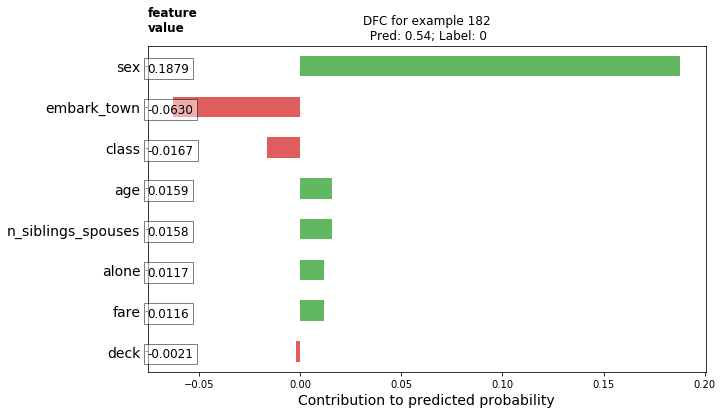

In [47]:
ID = 182
example = df_dfc.iloc[ID,:]

ax = plot_example(example)
ax.set_title("DFC for example {}\n Pred: {:1.2f}; Label: {}".format(
    ID, probs[ID], labels[ID]))
ax.set_xlabel('Contribution to predicted probability', size=14)
plt.show()

**The larger value indicates the more contribution to the prediction. The negative value indicates reducing the prediction.**


Next, you can plot the examples's DFCs compare with the entire distribution using a violin plot.

In [0]:
def dist_violin_plot(df_dfc, ID):
  fig, ax = plt.subplots(1, 1, figsize=(10, 6))

  TOP_N = 8
  _example = df_dfc.iloc[ID,:]
  ix = _example.abs().sort_values()[-TOP_N:].index
  example = _example[ix]
  dfexample = example.to_frame(name='dfc')

  parts = ax.violinplot([df_dfc[w] for w in ix], 
                        vert=False, 
                        showextrema=False, 
                        widths=0.7, 
                        positions=np.arange(len(ix)))
  face_color = sns_colors[0]
  alpha = 0.5
  for pc in parts['bodies']:
    pc.set_facecolor(face_color)
    pc.set_alpha(alpha)

  # add feature values
  _add_feature_values(_example[ix], ax)

  # add local contributions
  ax.scatter(example, np.arange(example.shape[0]), 
             color=sns.color_palette()[2], s=100, 
             marker="s", label="contributions for example")
  
  # legend
  ax.plot([0,0], [1,1], label='eval set contributions\ndistributions', 
          color=face_color, alpha=alpha, linewidth=10)
  legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large', 
                     frameon=True)
  legend.get_frame().set_facecolor('white')

  # format plot
  ax.set_yticks(np.arange(example.shape[0]))
  ax.set_yticklabels(example.index)
  ax.grid(False, axis='y')
  ax.set_xlabel('contribution to predicted probability', size=14)

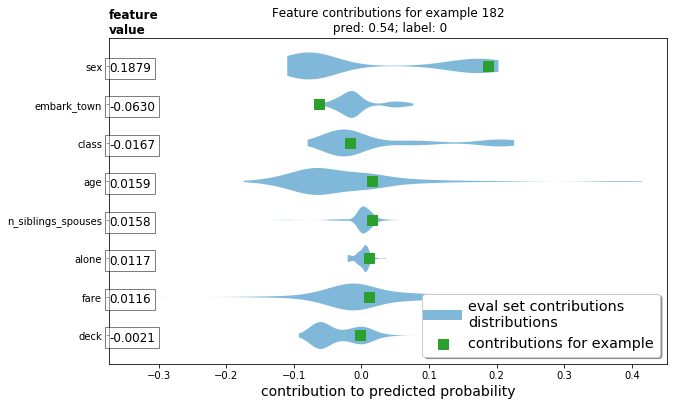

In [55]:
dist_violin_plot(df_dfc, ID)
plt.title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
plt.show()

# Global Feature Importances

Next, you are going to understand the model as a whole, rather than at the example level. Several cut-in ideas to uncover the feature importances.

* `Gain-based feature importances` via the `est.experimental_feature_importances` API
* Permutation importances
* Aggregate DFCs using the `est.experimental_predict_with_explanations`


## Gain-based feature importances

In [57]:
importances = est.experimental_feature_importances(normalize=True)
df_imp = pd.Series(importances)
df_imp

sex                   0.271086
fare                  0.223393
age                   0.204631
class                 0.114108
deck                  0.072481
embark_town           0.051351
n_siblings_spouses    0.037584
alone                 0.015080
parch                 0.010288
dtype: float64

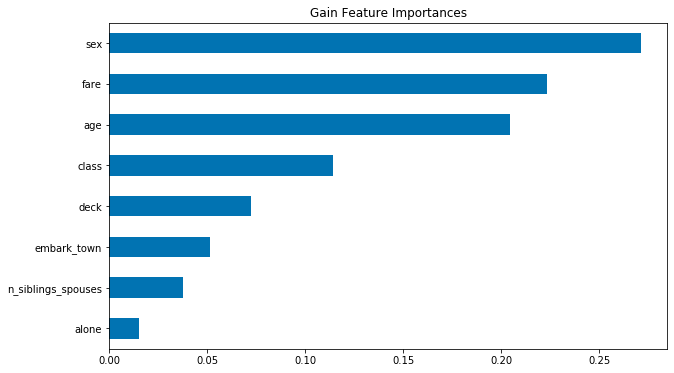

In [58]:
# visualize importances
N = 8
ax = (df_imp.iloc[0:N][::-1].plot(kind='barh', 
                                  color=sns_colors[0], 
                                  title='Gain Feature Importances', 
                                  figsize=(10, 6)))
ax.grid(False, axis='y')

## Average Absoluate DFCs

In [59]:
dfc_mean = df_dfc.abs().mean()
dfc_mean

sex                   0.112338
class                 0.063832
embark_town           0.025521
deck                  0.041231
age                   0.067284
fare                  0.058753
alone                 0.008270
n_siblings_spouses    0.010815
parch                 0.003227
dtype: float64

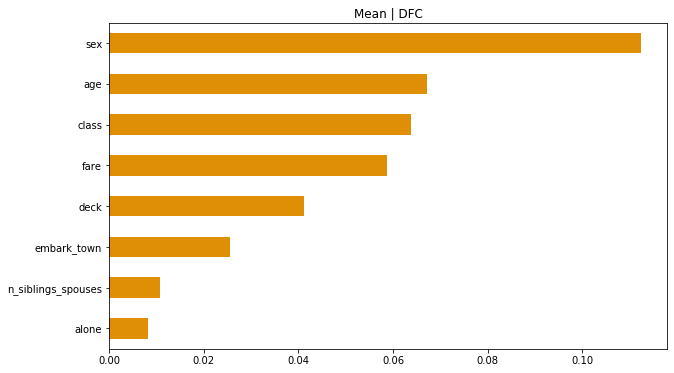

In [60]:
N = 8
sorted_ix = dfc_mean.abs().sort_values()[-N:].index
ax = dfc_mean[sorted_ix].plot(kind='barh', 
                              color=sns_colors[1], 
                              title='Mean | DFC',
                              figsize=(10, 6))
ax.grid(False, axis='y')

You can also see how much DFCs (continuous data) contribute to the prediction.

In [65]:
FEATURE = 'fare'
feature = pd.Series(df_dfc[FEATURE].values, index=dfeval[FEATURE].values).sort_index()
feature

0.0000      0.045916
0.0000     -0.007749
0.0000     -0.019532
4.0125     -0.007749
6.4500      0.004693
              ...   
151.5500    0.015334
151.5500    0.003833
211.3375   -0.070210
227.5250    0.199428
263.0000    0.007934
Length: 264, dtype: float64

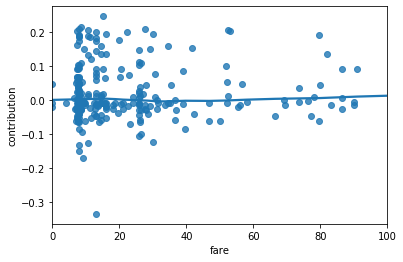

In [66]:
ax = sns.regplot(feature.index.values, feature.values, lowess=True)
ax.set_ylabel('contribution')
ax.set_xlabel(FEATURE)
ax.set_xlim(0, 100)
plt.show()

## Permutation feature importances

In [0]:
def permutation_importances(est, X_eval, y_eval, metric, features):
  """Column by column, shuffle values and observe effect on the eval set. (Drop-column importance.)"""

  baseline = metric(est, X_eval, y_eval)
  imp = []
  for col in features:
    save = X_eval[col].copy()
    X_eval[col] = np.random.permutation(X_eval[col])
    m = metric(est, X_eval, y_eval)
    X_eval[col] = save
    imp.append(baseline - m)
  return np.array(imp)

In [0]:
def accuracy_metric(est, X, y):
  eval_input_fn = make_input_fn(X, y, shuffle=False, n_epochs=1)
  return est.evaluate(input_fn=eval_input_fn)['accuracy']

In [0]:
features = CATEGORICAL_COLUMNS + NUMERIC_COLUMNS
importances = permutation_importances(est, dfeval, y_eval, 
                                      accuracy_metric, features)
df_imp = pd.Series(importances, index=features)
clear_output()

In [73]:
df_imp

sex                   0.193182
n_siblings_spouses    0.015152
parch                 0.003788
class                 0.049242
deck                  0.022727
embark_town           0.018939
alone                 0.007576
age                   0.068182
fare                  0.015152
dtype: float32

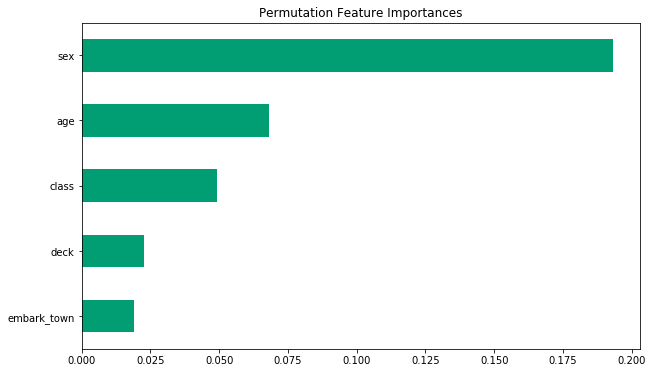

In [74]:
sorted_ix = df_imp.abs().sort_values().index
ax = df_imp[sorted_ix][-5:].plot(kind='barh', color=sns_colors[2], figsize=(10, 6))
ax.grid(False, axis='y')
ax.set_title('Permutation Feature Importances')
plt.show()

# Visualizing Model Fitting

Let's first create training data using the following formula.

$$z=xe^{-x^2-y^2}$$

Where z is the target and both x, y are the features.

In [0]:
from numpy.random import uniform, seed

In [0]:
seed(0)
npts = 5000
x = uniform(-2, 2, npts)
y = uniform(-2, 2, npts)
z = x * np.exp(-x*x-y*y)

In [0]:
df = pd.DataFrame({'x': x, 'y': y, 'z': z})

xi = np.linspace(-2., 2., 200)
yi = np.linspace(-2.1, 2.1, 210)
xi, yi = np.meshgrid(xi, yi)

df_predict = pd.DataFrame({
  'x': xi.flatten(),
  'y': yi.flatten()
})
predict_shape = xi.shape

In [98]:
predict_shape

(210, 200)

In [0]:
def plot_contour(x, y, z, **kwargs):
  plt.figure(figsize=(10, 8))
  CS = plt.contour(x, y, z, 15, linewidths=0.5, colors='k')
  CS = plt.contourf(x, y, z, 15, 
                    vmax=abs(zi).max(), vmin=-abs(zi).max(), cmap='RdBu_r')
  plt.colorbar()
  plt.xlim(-2, 2)
  plt.ylim(-2, 2)

In [0]:
zi = xi * np.exp(-xi*xi-yi*yi)

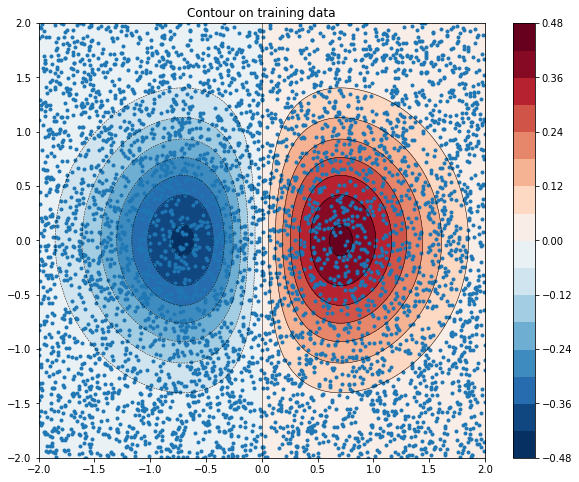

In [95]:
plot_contour(xi, yi, zi)
plt.scatter(df.x, df.y, marker='.')
plt.title('Contour on training data')
plt.show()

In [0]:
fc = [tf.feature_column.numeric_column('x'), 
      tf.feature_column.numeric_column('y')]

In [0]:
def predict(est):
  """Predictions from a given estimator."""
  predict_input_fn = lambda: tf.data.Dataset.from_tensors(dict(df_predict))
  preds = np.array([p['predictions'][0] for p in est.predict(predict_input_fn)])
  return preds.reshape(predict_shape)

Let's first try a linear regressor.

In [0]:
train_input_fn = make_input_fn(df, df.z)
est = tf.estimator.LinearRegressor(fc)
est.train(train_input_fn, max_steps=500)
clear_output()

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpubejzn4_/model.ckpt-8
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


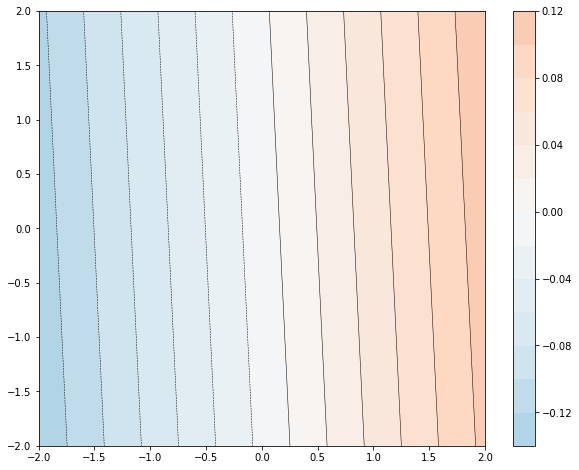

In [104]:
plot_contour(xi, yi, predict(est))

It seems not a good fit. Next, Let's try to fit a GBDT to it.

In [0]:
n_trees = 80

est = tf.estimator.BoostedTreesRegressor(fc, n_batches_per_layer=1, n_trees=n_trees)
est.train(train_input_fn, max_steps=500)
clear_output()

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpn2w6bf05/model.ckpt-7
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


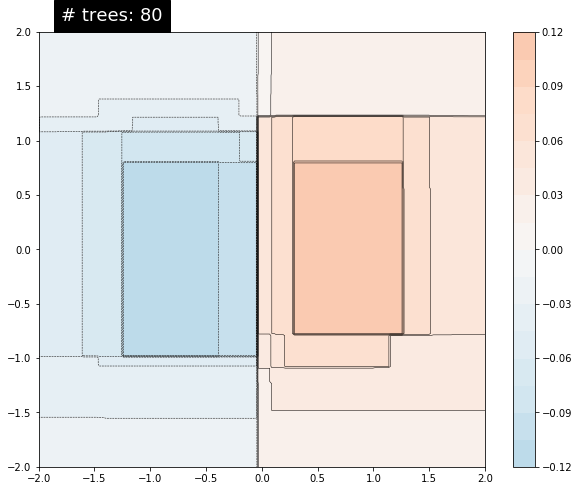

In [111]:
plot_contour(xi, yi, predict(est))
plt.text(-1.8, 2.1, '# trees: {}'.format(n_trees), color='w', backgroundcolor='black', size=18)
plt.show()